In [54]:
import warnings
warnings.simplefilter('ignore')

import re
import shap
import nltk
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC


# Download stopwords from nltk
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/avivshimoni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
# Function to clean the text
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words)


# Add models to the train_predict function
def train_predict(X_train, X_test, y_train, y_test):
    models = {
        'Linear SVM': LinearSVC(dual=False),
        'Random Forest': RandomForestClassifier(),
        'Naive Bayes': MultinomialNB(),
        'Logistic Regression': LogisticRegression(max_iter=1000)
    }
    
    trained_models = {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        trained_models[name] = y_pred
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{name} Accuracy:", accuracy)
    
    return trained_models

In [72]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def train_predict(X_train, X_test, y_train, y_test):
    # Define the parameter grids for each model
    param_grids = {
        'Linear SVM': {
            'C': [0.05, 1, 10, 100],
            'penalty': ['l2', 'l1']
        },
        'Random Forest': {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 100, 500]
        },
        'Naive Bayes': {
            'alpha': [0.1, 0.5, 1.0, 5.0]
        },
        'Logistic Regression': {
            'C': [0.1, 1, 10, 100],
            'penalty': ['l2', 'l1'],
            'solver': ['liblinear', 'saga']
        }
    }
    
    models = {
        'Linear SVM': LinearSVC(dual=False),
        'Random Forest': RandomForestClassifier(),
        'Naive Bayes': MultinomialNB(),
        'Logistic Regression': LogisticRegression(max_iter=1000)
    }
    
    trained_models = {}
    
    for name, model in models.items():
        print(f"Training {name}...")
        grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        trained_models[name] = y_pred
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{name} Best Params: {grid_search.best_params_}")
        print(f"{name} Accuracy:", accuracy)
    
    return trained_models

In [55]:
# Load the dataset
file_path = 'imdb_dataset.csv'
data = pd.read_csv(file_path)
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [56]:
# Apply the clean_text function to the review column
data['clean_review'] = data['review'].apply(clean_text)
data.head()

,review,sentiment,clean_review
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching oz episode ho...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically family little boy jake thinks zombie...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love time money visually stunnin...


In [73]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the clean review text
X = tfidf_vectorizer.fit_transform(data['clean_review'])

# Convert the sentiment labels to binary (0 for negative, 1 for positive)
y = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier and make predictions
y_pred = train_predict(X_train, X_test, y_train, y_test)

Training Linear SVM...
Linear SVM Best Params: {'C': 0.05, 'penalty': 'l2'}
Linear SVM Accuracy: 0.889
Training Random Forest...
Random Forest Best Params: {'max_depth': 500, 'n_estimators': 200}
Random Forest Accuracy: 0.8572
Training Naive Bayes...
Naive Bayes Best Params: {'alpha': 5.0}
Naive Bayes Accuracy: 0.8566
Training Logistic Regression...
Logistic Regression Best Params: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Logistic Regression Accuracy: 0.8927


#### Model Performance Summary

Logistic Regression demonstrated the highest accuracy at 0.8927. Given its performance, we have chosen the Logistic Regression model for our final implementation.

In [80]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"Classification Report:\n{report}")

Accuracy: 89.27%
Precision: 88.31%
Recall: 90.71%
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.88      0.91      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



#### Model Evaluation Results
The Logistic Regression model has demonstrated strong performance on our classification task.

The model's high accuracy, balanced precision, and recall indicate reliable and consistent performance across both classes, making it well-suited for our classification task.

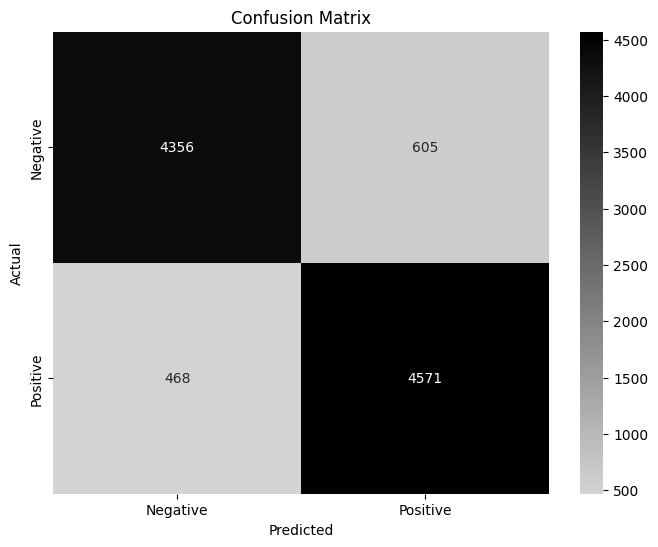

In [81]:
# Create a custom colormap
colors = ["lightgrey", "black"]
cmap = mcolors.LinearSegmentedColormap.from_list("custom_greys", colors)

# Plot the confusion matrix with the custom colormap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

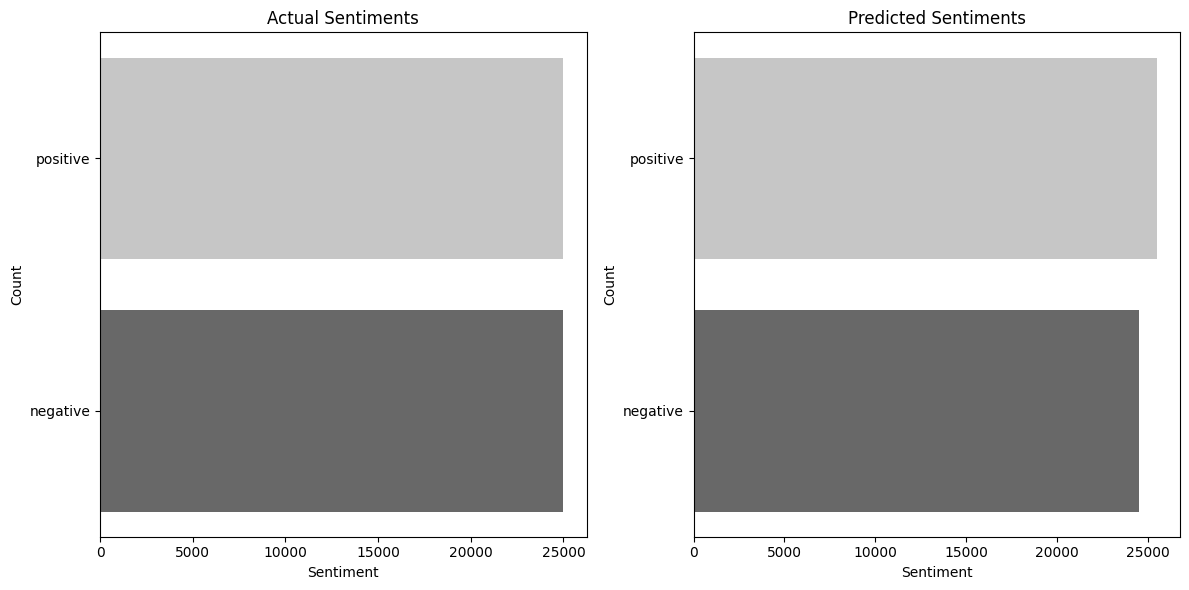

In [82]:
# Predict sentiment for the entire dataset
data['predicted_sentiment'] = model.predict(X)

# Plot the distribution of actual vs. predicted sentiments in black and white
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(data['sentiment'], palette="Greys")
plt.title('Actual Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(data['predicted_sentiment'].map({0: 'negative', 1: 'positive'}), palette="Greys")
plt.title('Predicted Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

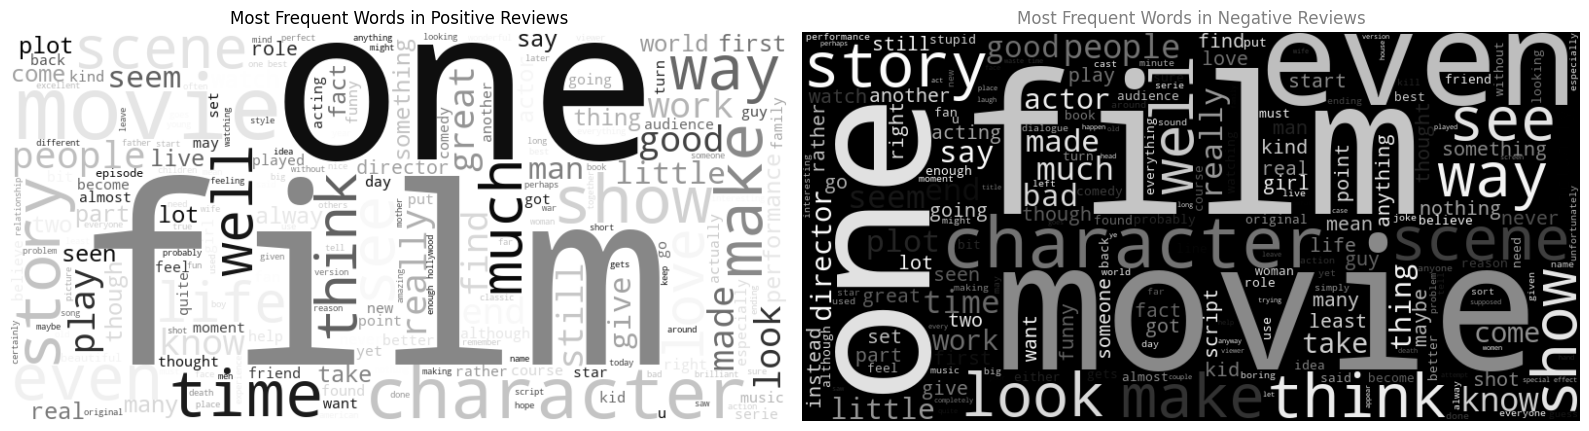

In [83]:
positive_reviews = ' '.join(data[data['predicted_sentiment'] == 1]['clean_review'])
negative_reviews = ' '.join(data[data['predicted_sentiment'] == 0]['clean_review'])

wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greys').generate(positive_reviews)
wordcloud_negative = WordCloud(width=800, height=400, background_color='black', colormap='Greys').generate(negative_reviews)

# Plot the word clouds
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Most Frequent Words in Positive Reviews', color='black')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Most Frequent Words in Negative Reviews', color='grey')
plt.axis('off')

plt.tight_layout()
plt.show()

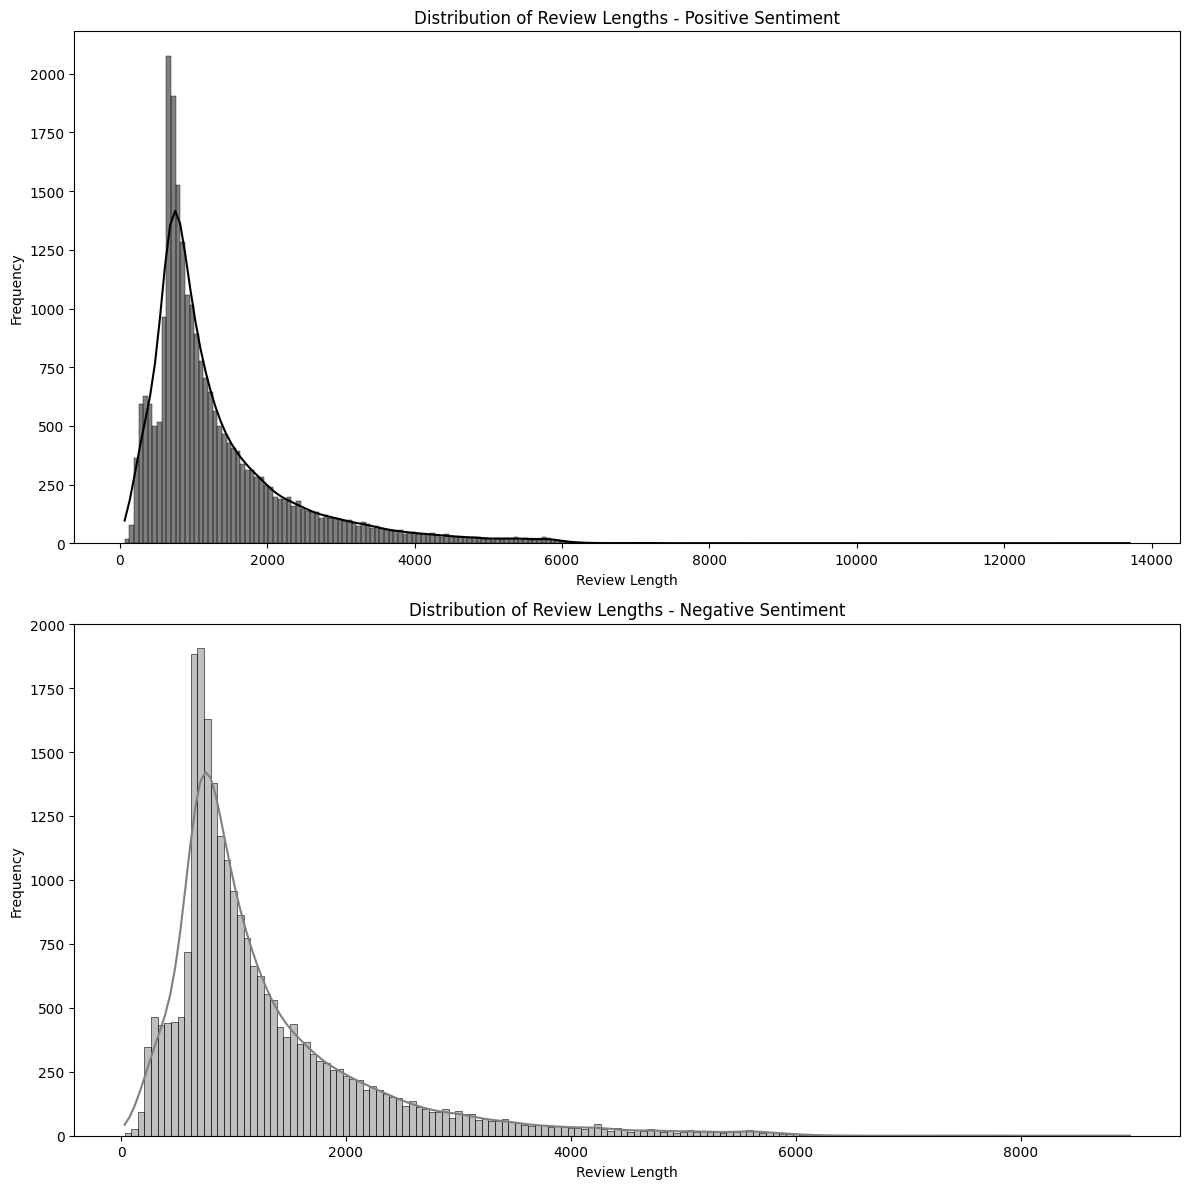

In [98]:
data['review_length'] = data['review'].str.len()

# Plot the distribution of review lengths by sentiment
plt.figure(figsize=(12, 12))

# Plot for positive reviews
plt.subplot(2, 1, 1)
sns.histplot(data[data['sentiment'] == 'positive']['review_length'], color='black', kde=True)
plt.title('Distribution of Review Lengths - Positive Sentiment')
plt.xlabel('Review Length')
plt.ylabel('Frequency')

# Plot for negative reviews
plt.subplot(2, 1, 2)
sns.histplot(data[data['sentiment'] == 'negative']['review_length'], color='grey', kde=True)
plt.title('Distribution of Review Lengths - Negative Sentiment')
plt.xlabel('Review Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

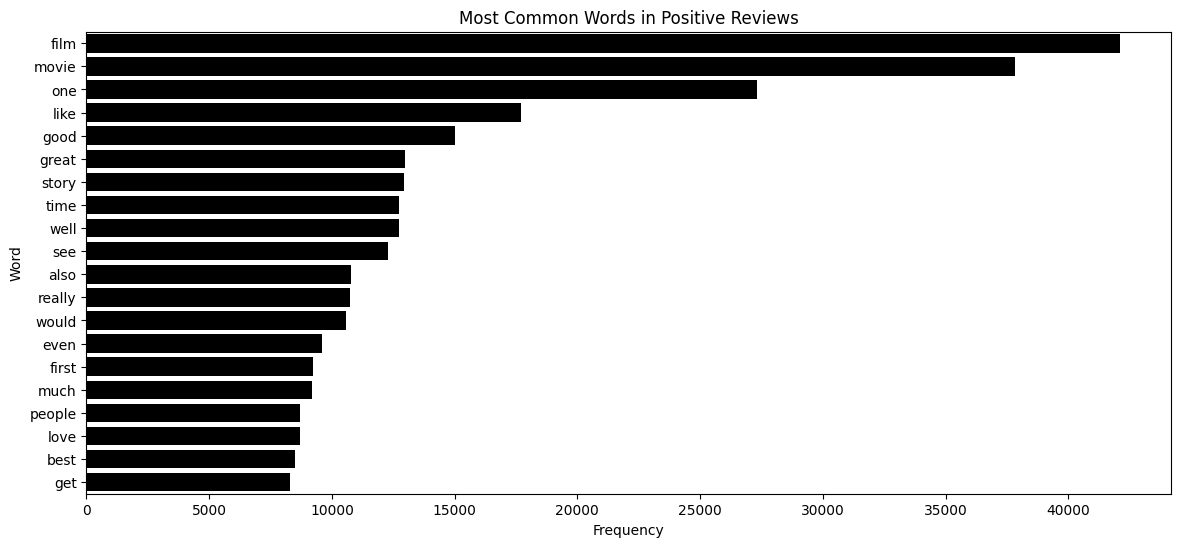

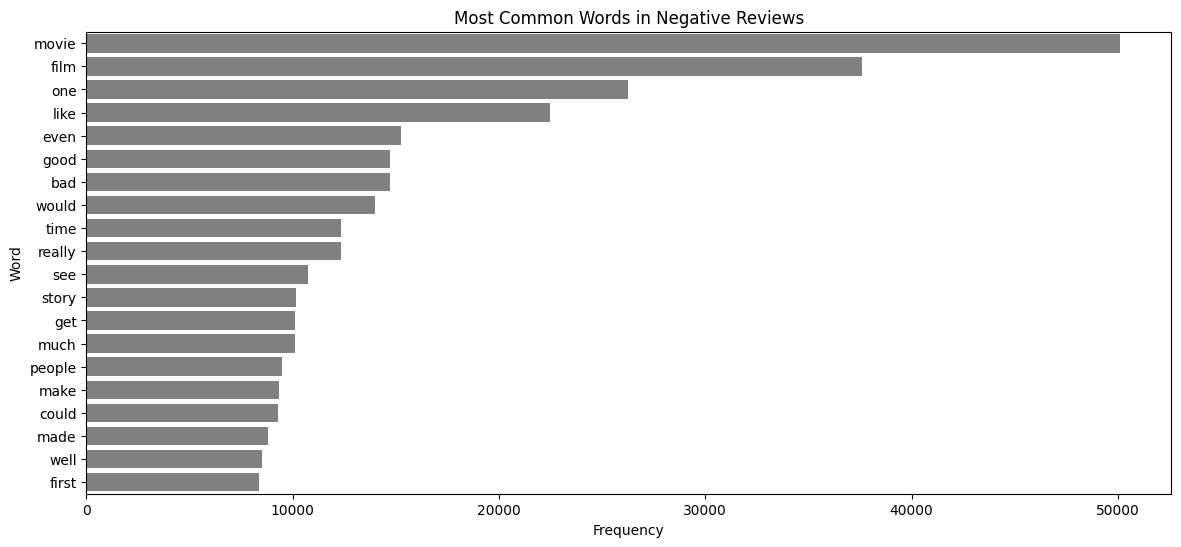

In [87]:
def plot_most_common_words(data, sentiment):
    words = ' '.join(data[data['sentiment'] == sentiment]['clean_review']).split()
    word_freq = Counter(words).most_common(20)
    # Convert to DataFrame for plotting
    word_df = pd.DataFrame(word_freq, columns=['word', 'frequency'])

# Get the most common words in positive and negative reviews
positive_words = ' '.join(data[data['sentiment'] == 'positive']['clean_review']).split()
negative_words = ' '.join(data[data['sentiment'] == 'negative']['clean_review']).split()

positive_word_freq = Counter(positive_words).most_common(20)
negative_word_freq = Counter(negative_words).most_common(20)

# Convert to DataFrame for plotting
positive_word_df = pd.DataFrame(positive_word_freq, columns=['word', 'frequency'])
negative_word_df = pd.DataFrame(negative_word_freq, columns=['word', 'frequency'])

# Plot the most common positive words
plt.figure(figsize=(14, 6))
sns.barplot(x='frequency', y='word', data=positive_word_df, color='black')
plt.title('Most Common Words in Positive Reviews')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

# Plot the most common negative words
plt.figure(figsize=(14, 6))
sns.barplot(x='frequency', y='word', data=negative_word_df, color='grey')
plt.title('Most Common Words in Negative Reviews')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

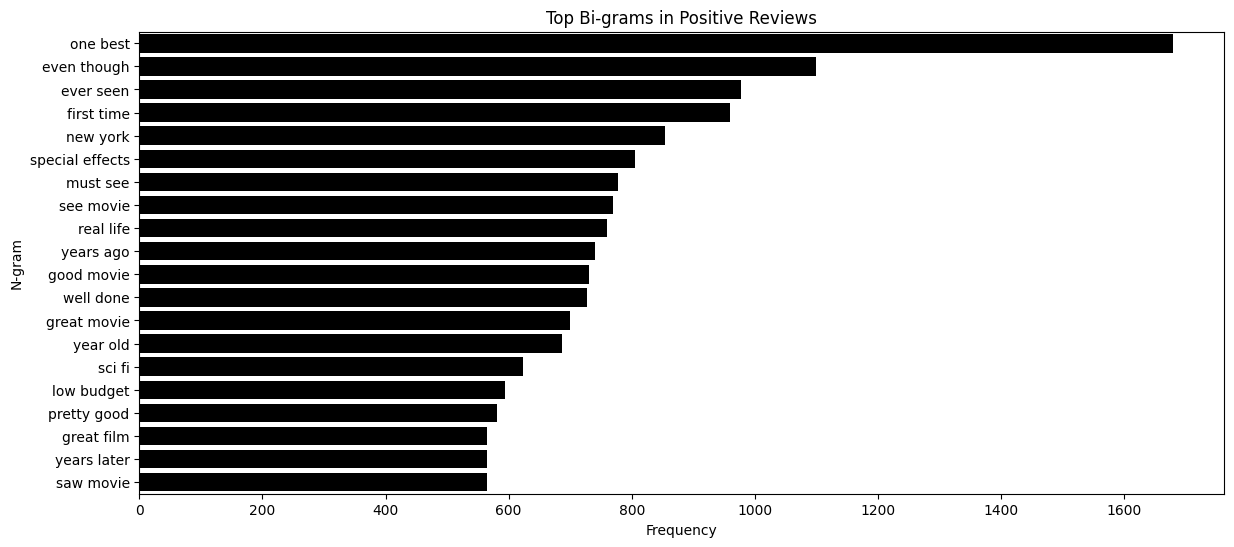

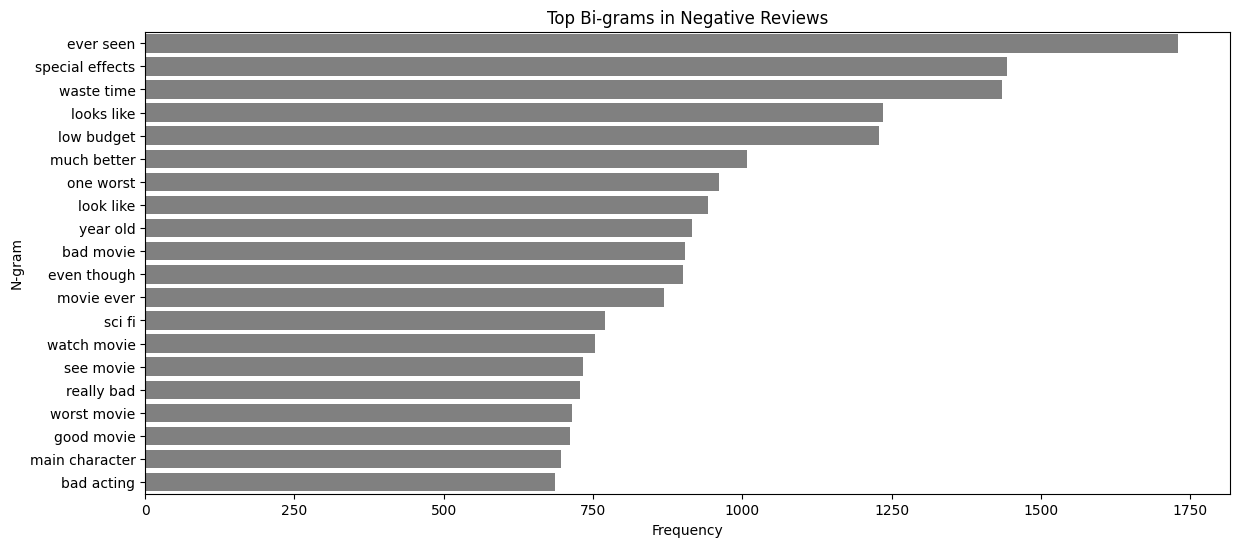

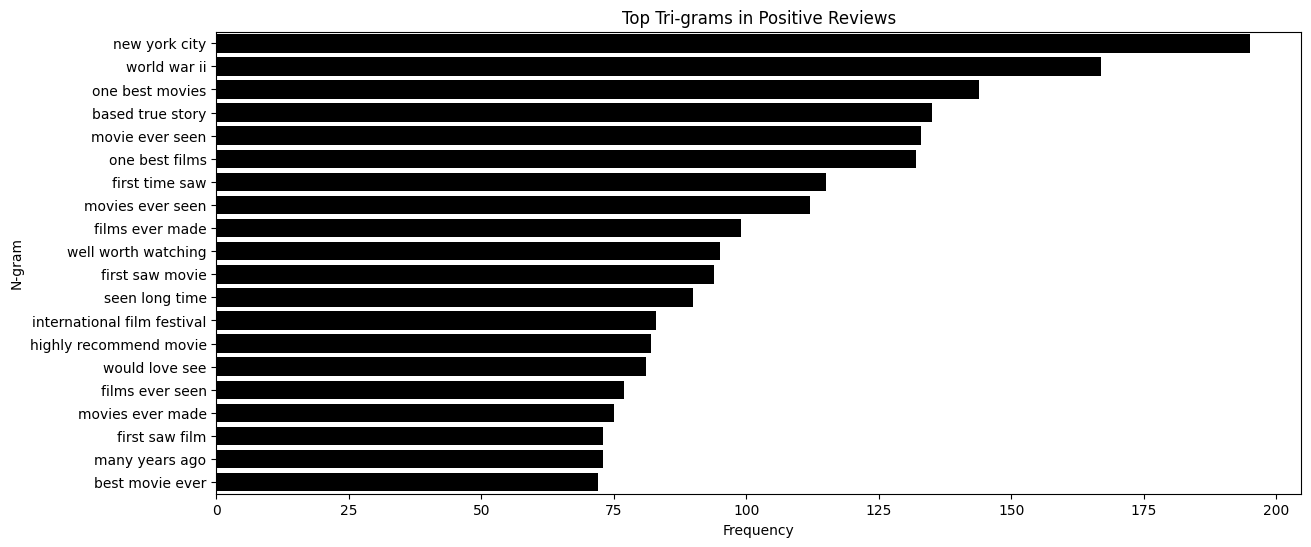

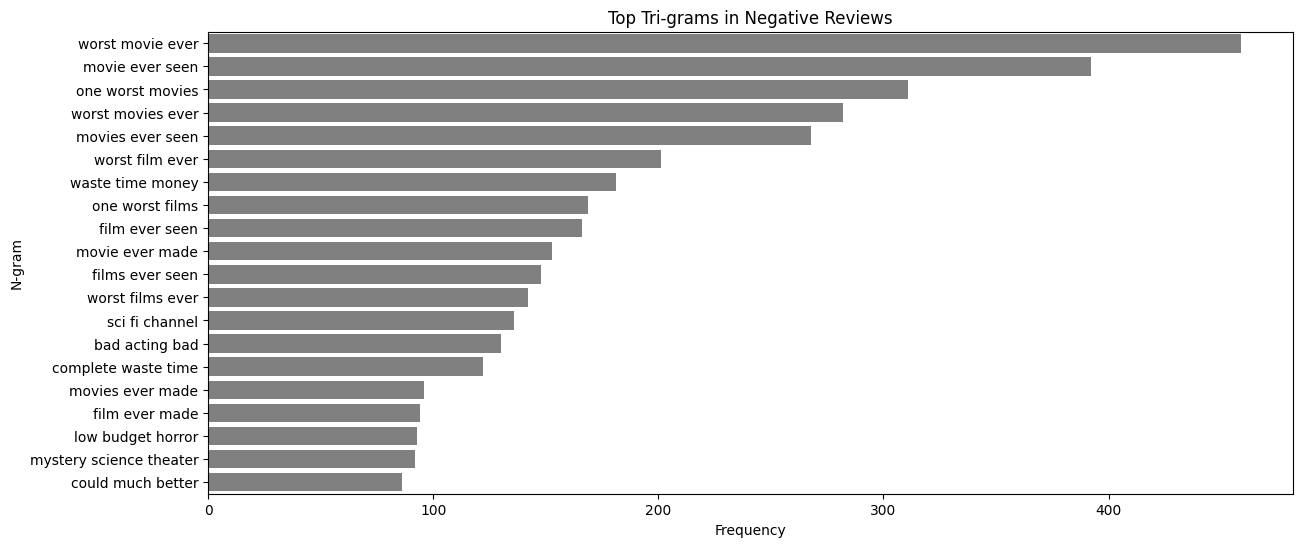

In [88]:
# Function to plot n-grams
def plot_ngrams(corpus, ngram_range, title, color):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:20]
    words_df = pd.DataFrame(words_freq, columns=['word', 'frequency'])
   
    plt.figure(figsize=(14, 6))
    sns.barplot(x='frequency', y='word', data=words_df, color=color)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('N-gram')
    plt.show()

# Plot bi-grams and tri-grams for positive and negative reviews
plot_ngrams(data[data['sentiment'] == 'positive']['clean_review'], (2, 2), 'Top Bi-grams in Positive Reviews', 'black')
plot_ngrams(data[data['sentiment'] == 'negative']['clean_review'], (2, 2), 'Top Bi-grams in Negative Reviews', 'grey')
plot_ngrams(data[data['sentiment'] == 'positive']['clean_review'], (3, 3), 'Top Tri-grams in Positive Reviews', 'black')
plot_ngrams(data[data['sentiment'] == 'negative']['clean_review'], (3, 3), 'Top Tri-grams in Negative Reviews', 'grey')

In [96]:
# Get the feature names and their corresponding coefficients
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = model.coef_[0]

# Create a DataFrame to store feature names and coefficients
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by absolute value of coefficients
feature_importance['AbsCoefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='AbsCoefficient', ascending=False)

# Select the top N important features
top_n = 20
top_features = feature_importance.head(top_n)

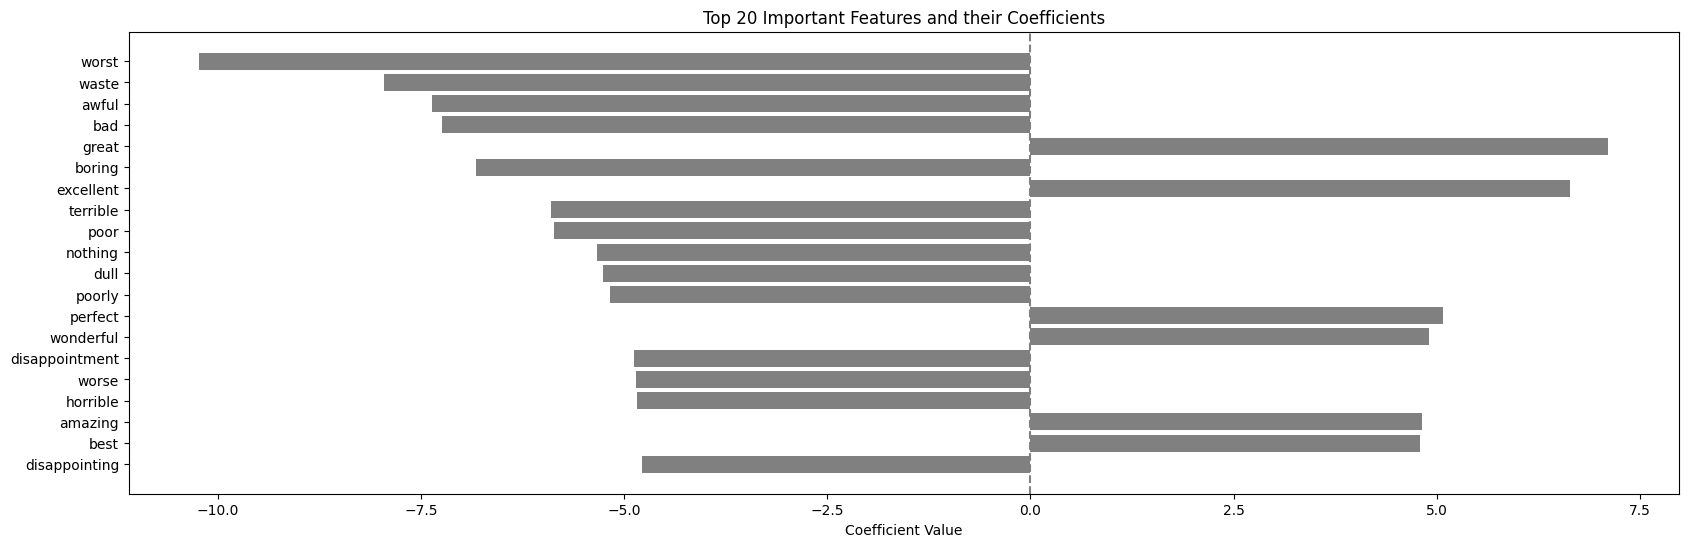

In [99]:
def create_simplified_nomogram(top_features):
    fig, ax = plt.subplots(figsize=(20, 6))
    
    # Plot the coefficients
    ax.barh(top_features['Feature'], top_features['Coefficient'], color='gray')
    ax.axvline(x=0, color='gray', linestyle='--')
    
    # Labels and title
    ax.set_xlabel('Coefficient Value')
    ax.set_title('Top 20 Important Features and their Coefficients')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient on top
    plt.show()

# Call the function to create the nomogram
create_simplified_nomogram(top_features)

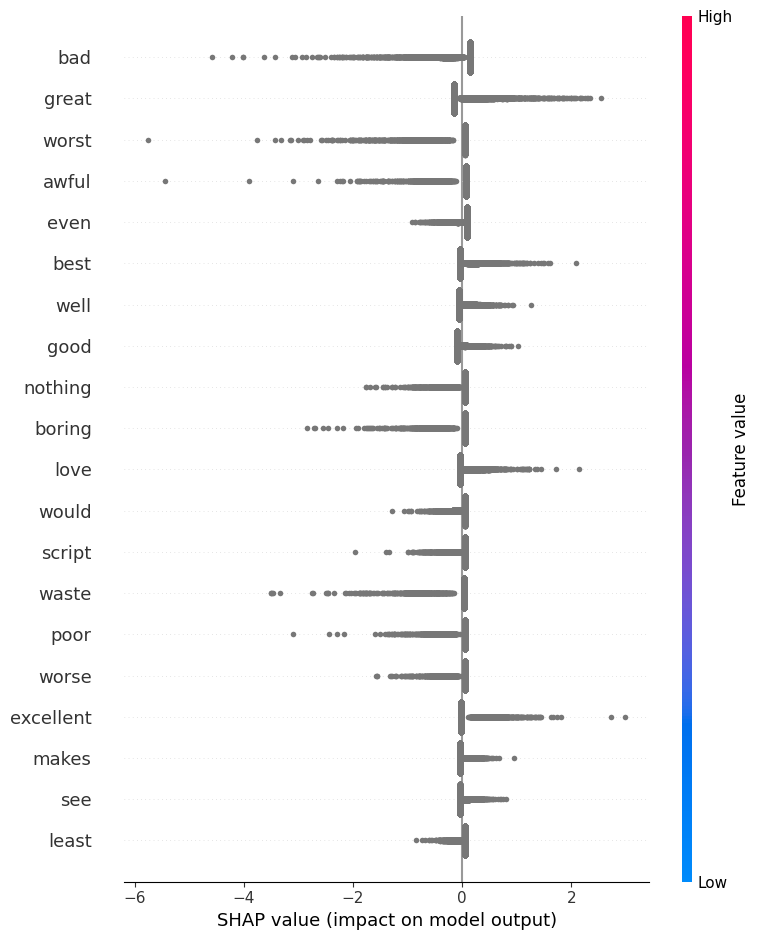

In [91]:
# Use SHAP to explain model predictions
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)

# Plot a summary plot
shap.summary_plot(shap_values, X_test, feature_names=tfidf_vectorizer.get_feature_names_out())

# Explain a single prediction
index = 0  # You can change this to any index of a sample you want to explain
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[index], feature_names=tfidf_vectorizer.get_feature_names_out())